# Lab 9-3: Dropout

- Overfitting
- Dropout
- Code: mnist_nn_dropout

# Overfitting

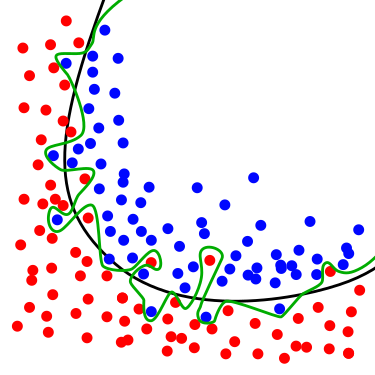

**과적합(Overfitting)**이란?  
말 그대로 학습 데이터를 과하게 학습(overfitting)하는 것을 뜻한다. 일반적으로 학습 데이타는 실제 데이터의 부분 집합이므로 학습 데이터에 대해서는 오차가 감소하지만 실제 데이터에 대해서는 오차가 증가하게 된다.
- 일반적으로 학습 데이타는 실제 데이타의 부분집합이며, 실제 데이타를 모두 수집하는 것은 불가능하다.
- 만약 실제 데이타를 모두 수집하여도 모든 데이타를 학습 시키기 위한 시간이 측정 불가능한 수준으로 증가할 수 있다.
- 학습 데이타만 가지고 실제 데이타의 오차가 증가하는 지점을 예측하는 것은 매우 어렵거나 불가능하다.

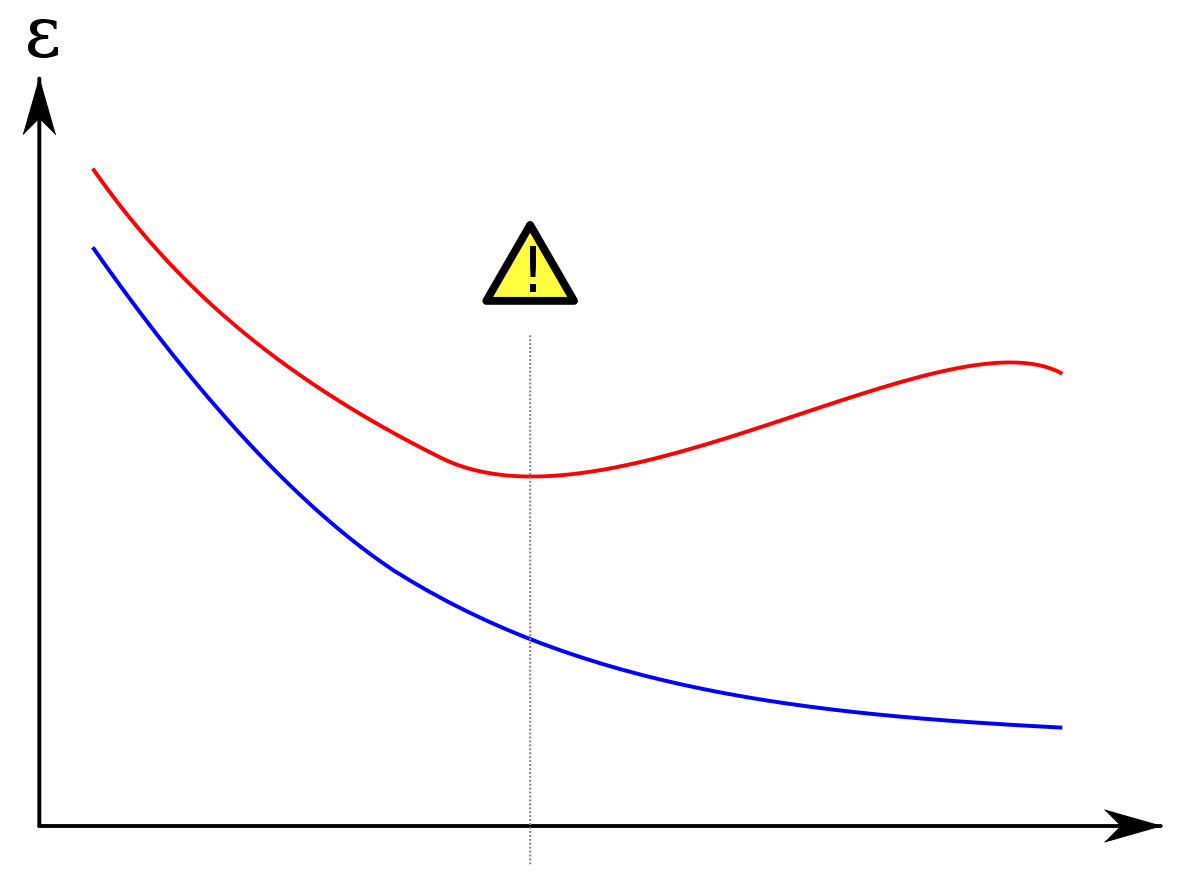

- Very high accuracy on the training dataset (e.g., 0.99)
- Poor accuracy on the test dataset (e.g., 0.85)

# Dropout

**Dropout**이란?  
Solutions for overfitting 중 하나로, 말 그대로 네트웍의 일부를 생략하는 것이다. 아래 그림처럼 네트웍의 일부를 생략하고 학습을 진행하게 되면, 생략한 네트웍은 학습에 영향을 끼치지 않게 된다.  
- 여러 개의 모델을 만드는 대신에 학습 사이클이 진행되는 동안 무작위로 일부 뉴런을 생략한다. 그렇게 되면 생략되는 뉴런의 조합만큼 지수함수적으로 다양한 모델을 학습시키는 것이나 마찬가지기 때문에 모델 결합의 효과를 누릴 수 있다.

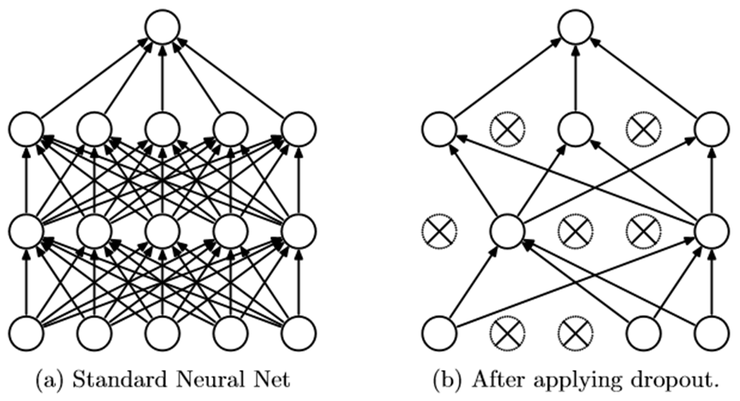

# Code: mnist_nn_dropout

In [1]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import random

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# for reproducibility
if device == 'cuda':
    torch.cuda.manual_seed_all(777)
else:
    torch.manual_seed(777)
    
# parameters
learning_rate = 0.001
training_epochs = 15
batch_size = 100
drop_prob = 0.3

# MNIST dataset
mnist_train = dsets.MNIST(root='MNIST_data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = dsets.MNIST(root='MNIST_data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

# dataset loader
data_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          drop_last=True)

In [2]:
# nn layers
linear1 = torch.nn.Linear(784, 512, bias=True)
linear2 = torch.nn.Linear(512, 512, bias=True)
linear3 = torch.nn.Linear(512, 512, bias=True)
linear4 = torch.nn.Linear(512, 512, bias=True)
linear5 = torch.nn.Linear(512, 10, bias=True)
relu = torch.nn.ReLU()
dropout = torch.nn.Dropout(p=drop_prob)

In [3]:
# xavier initialization
torch.nn.init.xavier_uniform_(linear1.weight)
torch.nn.init.xavier_uniform_(linear2.weight)
torch.nn.init.xavier_uniform_(linear3.weight)
torch.nn.init.xavier_uniform_(linear4.weight)
torch.nn.init.xavier_uniform_(linear5.weight)

Parameter containing:
tensor([[-0.0565,  0.0423, -0.0155,  ...,  0.1012,  0.0459, -0.0191],
        [ 0.0772,  0.0452, -0.0638,  ...,  0.0476, -0.0638,  0.0528],
        [ 0.0311, -0.1023, -0.0701,  ...,  0.0412, -0.1004,  0.0738],
        ...,
        [ 0.0334,  0.0187, -0.1021,  ...,  0.0280, -0.0583, -0.1018],
        [-0.0506, -0.0939, -0.0467,  ..., -0.0554, -0.0325,  0.0640],
        [-0.0183, -0.0123,  0.1025,  ..., -0.0214,  0.0220, -0.0741]],
       requires_grad=True)

In [4]:
# model
model = torch.nn.Sequential(linear1, relu, dropout,
                            linear2, relu, dropout,
                            linear3, relu, dropout,
                            linear4, relu, dropout,
                            linear5).to(device)

In [5]:
# define cost/loss & optimizer
criterion = torch.nn.CrossEntropyLoss().to(device)    # Softmax is internally computed.
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [6]:
total_batch = len(data_loader)
model.train()    # set the model to train mode (dropout=True)
for epoch in range(training_epochs):
    avg_cost = 0

    for X, Y in data_loader:
        # reshape input image into [batch_size by 784]
        # label is not one-hot encoded
        X = X.view(-1, 28 * 28).to(device)
        Y = Y.to(device)

        optimizer.zero_grad()
        hypothesis = model(X)
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))

print('Learning finished')

Epoch: 0001 cost = 0.310819715
Epoch: 0002 cost = 0.147846818
Epoch: 0003 cost = 0.112283744
Epoch: 0004 cost = 0.093249433
Epoch: 0005 cost = 0.083306551
Epoch: 0006 cost = 0.075156718
Epoch: 0007 cost = 0.068821006
Epoch: 0008 cost = 0.062357839
Epoch: 0009 cost = 0.059138797
Epoch: 0010 cost = 0.057410080
Epoch: 0011 cost = 0.050374191
Epoch: 0012 cost = 0.048644509
Epoch: 0013 cost = 0.049596094
Epoch: 0014 cost = 0.045847729
Epoch: 0015 cost = 0.044873897
Learning finished


In [ ]:
# Test model and check accuracy
with torch.no_grad():
    model.eval()    # set the model to evaluation mode (dropout=False)

    # Test the model using test sets
    X_test = mnist_test.test_data.view(-1, 28 * 28).float().to(device)
    Y_test = mnist_test.test_labels.to(device)

    prediction = model(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

    # Get one and predict
    r = random.randint(0, len(mnist_test) - 1)
    X_single_data = mnist_test.test_data[r:r + 1].view(-1, 28 * 28).float().to(device)
    Y_single_data = mnist_test.test_labels[r:r + 1].to(device)

    print('Label: ', Y_single_data.item())
    single_prediction = model(X_single_data)
    print('Prediction: ', torch.argmax(single_prediction, 1).item())

`model.train()` & `model.eval()`
- Sets the module in training/evaluation mode.
- This has any effect only on certain modules. See documentations of particular modules for details of their behaviors in training/evaluation mode, if they are affected, e.g. `Dropout`, `BatchNorm`, etc.

주의! train 할때는 dropout을 적용하지만, eval(test)일 때는 모든 노드를 사용해야하기 때문에 model.train()인 지 model.eval()인 지 잘 표시할 것!